In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle


In [ ]:
# Load the preprocessed data
file = open('/content/data_clean', 'rb')
data = pickle.load(file)

In [ ]:
data.head()

,Description,Caller,Assignment group
0,verified user detail employee manager name che...,spxjnwir pjlcoqds,GRP_0
1,gmail team meeting skype etc appearing outlook...,hmjdrvpb komuaywn,GRP_0
2,gmail can not log vpn best cant,eylqgodm ybqkwiam,GRP_0
3,unable access hr tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
# exclude GRP0
data = data[data['Assignment group'] != 'GRP_0']

In [ ]:
len(data['Assignment group'].value_counts())

49

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['Assignment group'] = label_encoder.fit_transform(data['Assignment group'])
  
data['Assignment group'].unique()

array([ 0, 22, 30, 38, 41, 45, 46,  1, 47,  2,  3,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 15, 16, 17,  4, 18, 19, 20, 21, 23, 24, 25, 26, 48,
       27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 44])

In [ ]:
Y = data['Assignment group'].values

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2288
Number of data points in test data: 716
Number of data points in cross validation data: 573


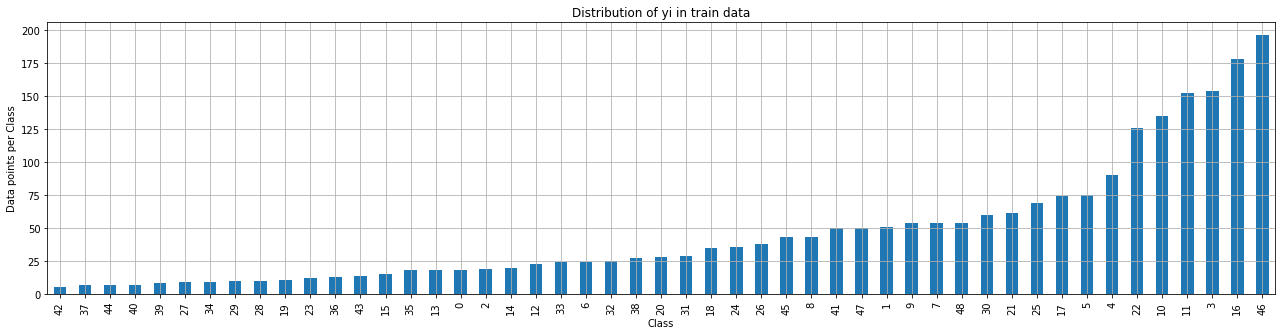

--------------------------------------------------------------------------------


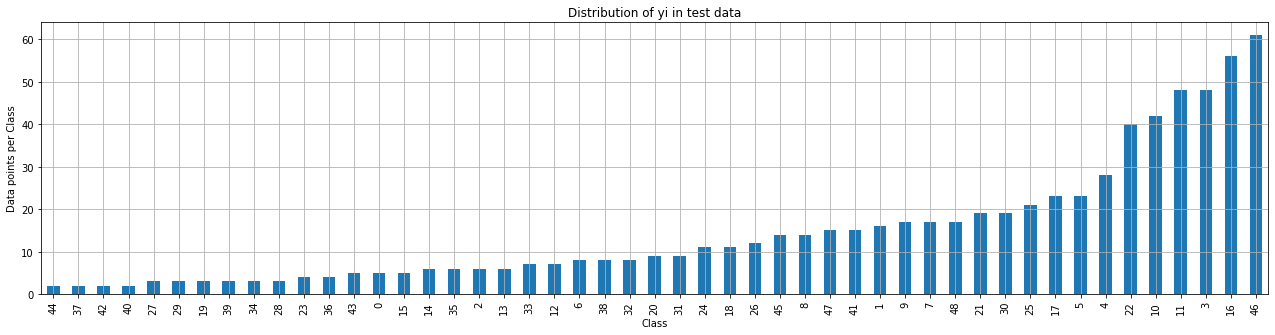

--------------------------------------------------------------------------------


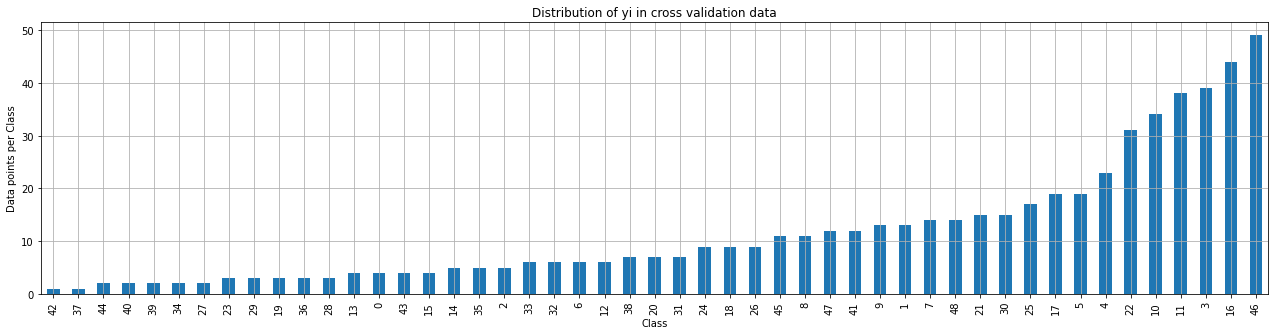

In [ ]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Assignment group'].value_counts().sort_values()
test_class_distribution = test_df['Assignment group'].value_counts().sort_values()
cv_class_distribution = cv_df['Assignment group'].value_counts().sort_values()

my_colors = 'rgbkymc'
plt.subplots(figsize=(22,5))
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
#sorted_yi = np.argsort(-train_class_distribution.values)
#for i in sorted_yi:
    #print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
plt.subplots(figsize=(22,5))
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
#sorted_yi = np.argsort(-test_class_distribution.values)
#for i in sorted_yi:
#    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
plt.subplots(figsize=(22,5))
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
#sorted_yi = np.argsort(-train_class_distribution.values)
#for i in sorted_yi:
    #print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

In [ ]:
maxOthers = X_train['Assignment group'].value_counts().max()
maxOthers

245

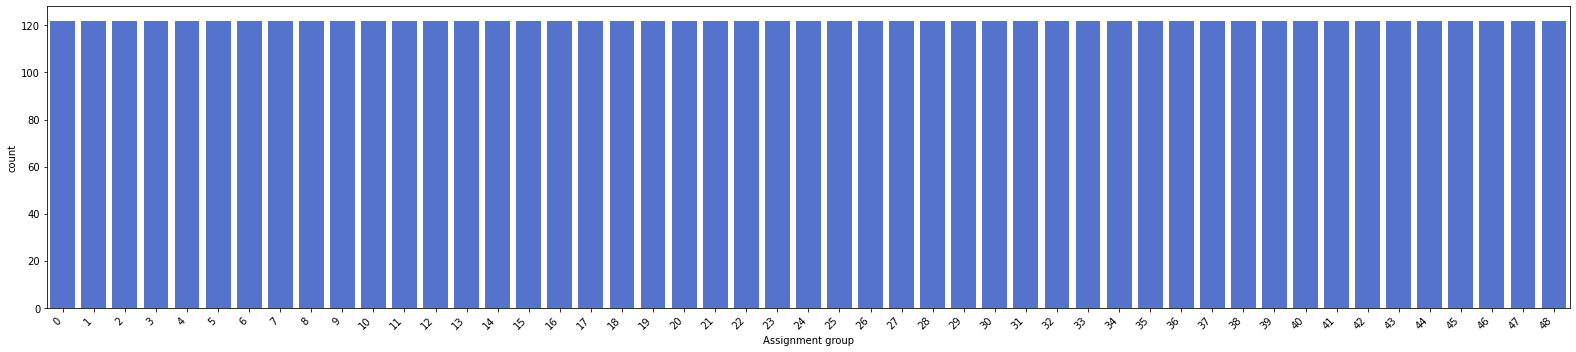

In [ ]:
from sklearn.utils import resample
data_resampled = X_train[0:0] #Copy columns

for grp in X_train['Assignment group'].unique():
  grp_data = X_train[X_train['Assignment group'] == grp]
  resampled = resample(grp_data, replace=True, n_samples=int(maxOthers/2), random_state=123)
  data_resampled = data_resampled.append(resampled)

descending_order = data_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=data_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Prediction using Random model

In [ ]:
# we need to generate 49 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,49))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,49)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,49))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,49)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

#predicted_y =np.argmax(test_predicted_y, axis=1)
#plot_confusion_matrix(y_test, predicted_y+1)

Log loss on Cross Validation Data using Random Model 4.191822123895184
Log loss on Test Data using Random Model 4.205181131789915


### Vectorizing Text feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [ ]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Description'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],50))
    for i in range(0,):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Description'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Description'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Description'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 2086


In [ ]:
dict_list = []
# dict_list =[] contains 50 dictoinaries each corresponds to a class
for i in range(0,49):
    cls_text = train_df[train_df['Assignment group']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,49):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Description'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Description'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

For values of alpha =  1e-05 The log loss is: 1.8911246466309513
For values of alpha =  0.0001 The log loss is: 1.8448996159804467
For values of alpha =  0.001 The log loss is: 2.0180084774962643
For values of alpha =  0.01 The log loss is: 2.8170591472010624
For values of alpha =  0.1 The log loss is: 3.2021444914938053
For values of alpha =  1 The log loss is: 3.2470691050339657


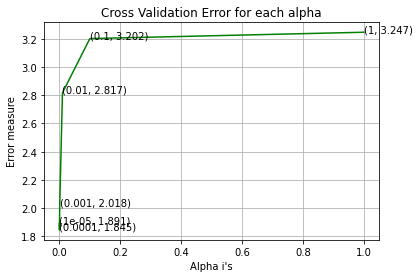

For values of best alpha =  0.0001 The train log loss is: 0.9062188907545695
For values of best alpha =  0.0001 The cross validation log loss is: 1.8448996159804467
For values of best alpha =  0.0001 The test log loss is: 1.8082882499835307


In [ ]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
train_y = np.array(list(train_df['Assignment group']))
test_y = np.array(list(test_df['Assignment group']))
cv_y = np.array(list(cv_df['Assignment group']))

### Baseline Model

#### Naive Bayes

##### Hyper parameter tuning

for alpha = 1e-05
Log Loss : 2.482753769978142
for alpha = 0.0001
Log Loss : 2.4403159293562764
for alpha = 0.001
Log Loss : 2.3839380806701453
for alpha = 0.1
Log Loss : 2.2376466389615106
for alpha = 1
Log Loss : 2.162225487208957
for alpha = 10
Log Loss : 2.2092305760040314
for alpha = 100
Log Loss : 2.1518290834314024
for alpha = 1000
Log Loss : 2.1608088061544515


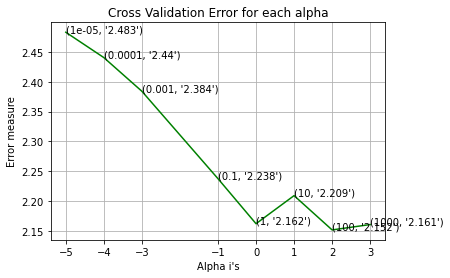

For values of best alpha =  100 The train log loss is: 1.6408062956308955
For values of best alpha =  100 The cross validation log loss is: 2.1518290834314024
For values of best alpha =  100 The test log loss is: 2.06918345201559


In [ ]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing with best hyper parameter

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 2.1518290834314024
Number of missclassified point : 0.5130890052356021


#### KNN

##### Hyperparameter tuning

for alpha = 5
Log Loss : 2.4717128675123394
for alpha = 11
Log Loss : 2.4411801400007245
for alpha = 15
Log Loss : 2.427747416287437
for alpha = 21
Log Loss : 2.4083408293321713
for alpha = 31
Log Loss : 2.4533664540712987
for alpha = 41
Log Loss : 2.480672825247597
for alpha = 51
Log Loss : 2.5036488305978075
for alpha = 99
Log Loss : 2.5096301284010467


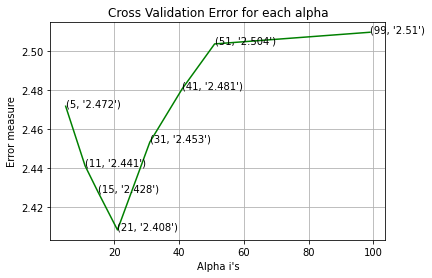

For values of best alpha =  21 The train log loss is: 1.9114891033416108
For values of best alpha =  21 The cross validation log loss is: 2.4083408293321713
For values of best alpha =  21 The test log loss is: 2.4303295928440987


In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

##### Testing with best hyperparameter

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 2.4083408293321713
Number of missclassified point : 0.5846422338568935


##### Sample query point 1

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_text_feature_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_text_feature_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 46
Actual Class : 11
The  21  nearest neighbours of the test points belongs to classes [11 31 45 24 10 37 48 37 37 26 43 10 20 23 16 22 21 45 22  3 23]
Fequency of nearest points : Counter({37: 3, 45: 2, 10: 2, 23: 2, 22: 2, 11: 1, 31: 1, 24: 1, 48: 1, 26: 1, 43: 1, 20: 1, 16: 1, 21: 1, 3: 1})


##### Sample Query Point 2

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(test_text_feature_onehotCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_text_feature_onehotCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 46
Actual Class : 32
The  21  nearest neighbours of the test points belongs to classes [26  4 34  5  6 22 33 43 23 20  3 11 37 26 48 37 37 43 48 11 46]
Fequency of nearest points : Counter({37: 3, 26: 2, 43: 2, 11: 2, 48: 2, 4: 1, 34: 1, 5: 1, 6: 1, 22: 1, 33: 1, 23: 1, 20: 1, 3: 1, 46: 1})


### Logistic regression

With Class balancing

for alpha = 1e-06
Log Loss : 2.038700720717991
for alpha = 1e-05
Log Loss : 1.8623144419438238
for alpha = 0.0001
Log Loss : 1.8626511554688903
for alpha = 0.001
Log Loss : 2.0653590016790124
for alpha = 0.01
Log Loss : 2.977406139474349
for alpha = 0.1
Log Loss : 3.3050463143216726
for alpha = 1
Log Loss : 3.3294033005102093
for alpha = 10
Log Loss : 3.331853623740969
for alpha = 100
Log Loss : 3.3316679077580673


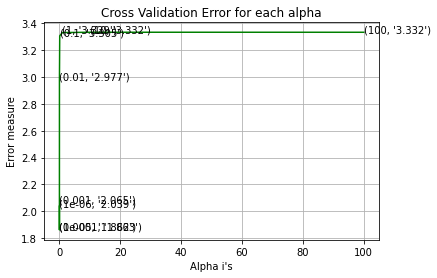

For values of best alpha =  1e-05 The train log loss is: 0.7860085636453252
For values of best alpha =  1e-05 The cross validation log loss is: 1.8623144419438238
For values of best alpha =  1e-05 The test log loss is: 1.8738866644671839


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 1.8623144419438238
Number of missclassified point : 0.44153577661431065


#### Without class balancing 

for alpha = 1e-06
Log Loss : 2.0656851882999328
for alpha = 1e-05
Log Loss : 1.8911246466309513
for alpha = 0.0001
Log Loss : 1.8448996159804467
for alpha = 0.001
Log Loss : 2.0180084774962643
for alpha = 0.01
Log Loss : 2.8170591472010624
for alpha = 0.1
Log Loss : 3.2021444914938053
for alpha = 1
Log Loss : 3.2470691050339657


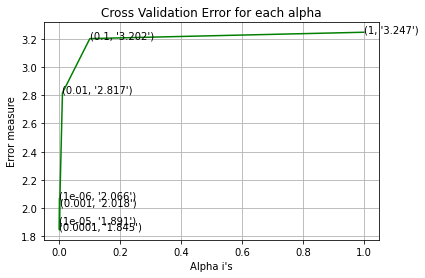

For values of best alpha =  0.0001 The train log loss is: 0.9062188907545695
For values of best alpha =  0.0001 The cross validation log loss is: 1.8448996159804467
For values of best alpha =  0.0001 The test log loss is: 1.8082882499835307


In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 1.7991278739591052
Number of missclassified point : 0.4675090252707581


### Linear Support Vector Machines

#### Hyper parameter tuning

for C = 1e-05
Log Loss : 2.0466430577475276
for C = 0.0001
Log Loss : 1.940739168635734
for C = 0.001
Log Loss : 1.9598895940448224
for C = 0.01
Log Loss : 1.9842368904853998
for C = 0.1
Log Loss : 3.3309557554597076
for C = 1
Log Loss : 3.351855941115196
for C = 10
Log Loss : 3.351858107683003
for C = 100
Log Loss : 3.352163682784615


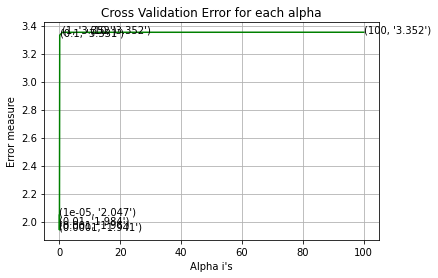

For values of best alpha =  0.0001 The train log loss is: 1.013310931338281
For values of best alpha =  0.0001 The cross validation log loss is: 1.940739168635734
For values of best alpha =  0.0001 The test log loss is: 2.0573338883587846


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 1.940739168635734
Number of missclassified point : 0.4566787003610108


### Random Forest

#### Hyper parameter tuning

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_text_feature_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_text_feature_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 2.3199140059483523
for n_estimators = 100 and max depth =  10
Log Loss : 2.209598642325925
for n_estimators = 200 and max depth =  5
Log Loss : 2.2584168507270785
for n_estimators = 200 and max depth =  10
Log Loss : 2.169991177012421
for n_estimators = 500 and max depth =  5
Log Loss : 2.2334346251259003
for n_estimators = 500 and max depth =  10
Log Loss : 2.158666906667035
for n_estimators = 1000 and max depth =  5
Log Loss : 2.231512693271258
for n_estimators = 1000 and max depth =  10
Log Loss : 2.1512978863999366
for n_estimators = 2000 and max depth =  5
Log Loss : 2.232614163108823
for n_estimators = 2000 and max depth =  10
Log Loss : 2.150516943463733
For values of best estimator =  2000 The train log loss is: 1.3526626196141147
For values of best estimator =  2000 The cross validation log loss is: 2.150516943463733
For values of best estimator =  2000 The test log loss is: 2.0658912959993736


In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_text_feature_onehotCoding)- cv_y))/cv_y.shape[0])
#plot_confusion_matrix(cv_y, sig_clf.predict(cv_text_feature_onehotCoding.toarray()))

Log Loss : 2.150516943463733
Number of missclassified point : 0.5270758122743683


### Stacking the models

In [ ]:
clf1 = SGDClassifier(alpha=0.00001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_text_feature_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_text_feature_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.1)
clf3.fit(train_text_feature_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_text_feature_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_text_feature_onehotCoding))))
sig_clf2.fit(train_text_feature_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_text_feature_onehotCoding))))
sig_clf3.fit(train_text_feature_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_text_feature_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_text_feature_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_text_feature_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_text_feature_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.86
Support vector machines : Log Loss: 1.94
Naive Bayes : Log Loss: 2.12
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 3.481
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 3.449
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 3.172
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 2.352
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.991
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.275


In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_text_feature_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_text_feature_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_text_feature_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_text_feature_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_text_feature_onehotCoding)- test_y))/test_y.shape[0])
#plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

Log loss (train) on the stacking classifier : 1.2826024609679336
Log loss (CV) on the stacking classifier : 1.733438695211817
Log loss (test) on the stacking classifier : 1.7448249822514572
Number of missclassified point : 0.35611510791366907


In [ ]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_text_feature_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_text_feature_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_text_feature_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_text_feature_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_text_feature_onehotCoding)- test_y))/test_y.shape[0])
#plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_text_feature_onehotCoding))

Log loss (train) on the VotingClassifier : 1.0230551034096496
Log loss (CV) on the VotingClassifier : 1.49549255304332
Log loss (test) on the VotingClassifier : 1.5732022157869492
Number of missclassified point : 0.3537170263788969
